<a href="https://colab.research.google.com/github/EAkeweje/GEOMETRIC-LEARNING-FOR-FLOWS-IN-POROUS-SYSTEMS/blob/main/Linear%20SNDs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Ignore this cell. 
#for access to data files
%cd /content/drive/MyDrive/Skoltech/Research/GDL

/content/drive/MyDrive/Skoltech/Research/GDL


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torchinfo import summary
import PIL
import pandas as pd
from statsmodels.nonparametric.kernel_regression import KernelReg
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
import glob
import copy
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Utilis

## Core Functions

Next cell contains function written and useful to this project

In [ ]:
#functions written for this research project
#rotate image 90 degrees clockwise
def show_pore(A):
  plt.imshow(np.rot90(A), cmap='Greys')
  plt.axis('off');
  plt.show()
  return

#pixel to graph
def pix_to_graph(A, kernel_size=1, scaled = False, flip = False, rotate = True):
  '''
  inputs: takes 2 inputs
  - pore array, and
  - kernel_size; for coarse-graining... default set to 1 if there is no coarse graining.
  - Scaled: This determines where the node position features stores the coarse grained position or a kernel size enlarge versio
  
  outputs: returns 4 outputs
  -a pore network whose nodes stors their location, 
  - number of nodes in the network,
  - number of edges in the network, and
  - number of clusters the network has.
  '''
  if flip:
    A = np.flip(A,1) #flip to aid visualization
  if rotate:
    A = np.rot90(A)
  G_T = nx.Graph()
  k,l = A.shape
  for i in range(k):
    for j in range(l):
      if A[i,j] <= kernel_size**2/2:
        #add node and save node's position
        if not scaled:
          G_T.add_node(i*l+j,pos = (i,j))
        else:
          G_T.add_node(i*l+j,pos = (kernel_size*i,kernel_size*j))
        for coord in [(i+1,j),(i-1,j),(i,j+1),(i,j-1)]: #check 4 neighbours
          if 0<=coord[0]<k and 0<=coord[1]<l:
            if A[coord[0],coord[1]] <= kernel_size**2/2:
              #add node and save node's position
              if not scaled:
                G_T.add_node(coord[0]*l+coord[1],pos = (coord[0],coord[1]))
              else:
                G_T.add_node(coord[0]*l+coord[1],pos = (kernel_size*coord[0],kernel_size*coord[1]))
              #add edge
              G_T.add_edge(i*l+j,coord[0]*l+coord[1])
  return G_T, G_T.number_of_nodes(), G_T.number_of_edges(), len(list(nx.connected_components(G_T)))

def node_pos(G_T):
  '''
  inputs: takes the pore network
  outputs: return a dictionary whose keys are the node identity 
  nd values are their respective locations.
  '''
  node_pos= {}
  for node in G_T.nodes:
    node_pos[node] = list(G_T.nodes[node].values())[0]
  return node_pos

def coarse_grain(img_array,kernel_size):
  #only square images are supported
  if img_array.shape[0]%kernel_size == 0: #and img_array[1]%kernel_size == 0:
    m = nn.Conv2d(1,1,kernel_size=kernel_size,stride= kernel_size,bias=False)
  else:
    #padding required if image size is indivisible by kernel size
    pad = int((kernel_size - img_array.shape[0]%kernel_size)/2)
    m = nn.Conv2d(1,1,kernel_size=kernel_size,stride= kernel_size,bias=False, padding=pad)
  weights = torch.ones_like(m.weight)
  with torch.no_grad():
      m.weight = nn.Parameter(weights)
  img_array = torch.from_numpy(img_array.copy()).reshape((1,1)+img_array.shape)
  CG= m(img_array.float()).detach().numpy().squeeze()
  return CG

def porenet_image(A,kernel_size=1, s=15, flip = True, rotate = False):
  '''
  inputs: takes three imputs
  - A: The pore array,
  - kernel_size: size of kernel for coarse graining operation, and
  - s: The figure size... default set to 15
  outputs: visualization of pore network on image
  '''
  #construct graph
  if kernel_size == 1:
    G_T,n,e,c = pix_to_graph(A, flip = flip, rotate = rotate)
  else:
    G_T,n,e,c = pix_to_graph(coarse_grain(A,kernel_size),kernel_size, scaled = True, flip = flip, rotate = rotate)
  print(f'{n} nodes, {e} edges, and {c} clusters')
  #visualization
  fig = plt.figure(figsize=(s,s))
  plt.imshow(np.rot90(A), cmap='Greys')
  nx.draw(G_T,pos = node_pos(G_T))
  # ax.axis("off");
  plt.show()
  return G_T

def get_total_space(array):
    '''
    Input
    array: binary structure array of porous/complex structure with 0 representing the free space and 1 representing the solids
    Returns
    A list of indices of spaces in porous/complex structure
    '''
    output = []
    for i in np.transpose(np.nonzero(array==0)):
        output.append(tuple(i))
    return output

In [ ]:
#pore image to pore array
def gen_pore_array(img_path:str):
  an_image = PIL.Image.open(img_path)
  image_sequence = an_image.getdata()
  image_array = np.array(image_sequence)/255
  k = np.asarray(an_image)[:,:,0]/255
  #adjustment so that the pore spaces are mapped to 0 and the solid immovable parts mapped to 1
  pore_array = np.ones_like(k) - k
  return pore_array

## Data Preprocessing:
Making a custom torch dataloader

In [ ]:
'''
Change directory to any pore image. The function, gen_pore_array, converts the pore image to pore array.
If you choose to use a pore array then use
pore_array = 'path_to_pore array'
'''
pore_array = gen_pore_array("./Dataset/Fluid Flow Simulation/1.png")

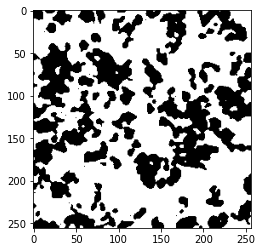

In [ ]:
plt.imshow(pore_array,'binary')

In [ ]:
#choose kernel size for coarse-graining
def data_process(pore_array,ks, vel_dir):
  '''
  Takes: 
  pore_array: array of pore space
  ks: coarse-graining (kernel) size,
  vel_dir : path to velocity profile and
  Returns:
  f : velocity data, 
  CG_G : graph (from coarse graining), 
  CG_f : [CG_f_0,CG_f_1]; a list of coarse-grained velocity data, 
  x : position data for training non-geometric method,
  y : [y_0,y_1]; a list of training traget for non-geometric method
  '''
  #use coarse graining with (2,2) kernel then contrust pore network
  CG_G,n,e,c = pix_to_graph(coarse_grain(pore_array,kernel_size=ks),kernel_size=ks);
  print(f'The generated pore network has {n} nodes')

  #loading and coarse-graining fluid velocity field
  f = np.loadtxt(vel_dir)
  f = np.reshape(f,(256,256,2))
  f = np.rot90(f)
  #coarse graining with a 2*2 kernel
  # ks = 2 #kernel size
  CG_f_0 = coarse_grain(f[:,:,0],ks)/(ks*ks)
  CG_f_1 = coarse_grain(f[:,:,1],ks)/(ks*ks)
  CG_f = [CG_f_0, CG_f_1]

  #creating X and Y
  # x = np.array([[i[0] for i in list(node_pos(CG_G).values())],[i[1] for i in list(node_pos(CG_G).values())]])
  # y_0 = np.array([CG_f_0[i] for i in list(node_pos(CG_G).values())])
  # y_1 = np.array([CG_f_1[i] for i in list(node_pos(CG_G).values())])
  # y = [y_0,y_1]
  return f, CG_G, CG_f

In [ ]:
#Utilis for Inversion
def get_bounds(array):
  '''
  array : array of pore space
  returns a list of boundary turples
  To draw contour: obtain contours from cv2.findContours()
  - use image = cv2.drawContours(image, contours, -1, (0, 255, 0), 0)
  - plt.imshow(image)
  '''
  # image = cv2.imread(img_path)
  # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  array = array.astype(np.uint8)#adjusting
  contours, hierarchy = cv2.findContours(array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  boundary_points = []
  for i,pts in enumerate(contours):
    if pts.shape[0] == 1:
      pt = pts.squeeze().tolist()
      boundary_points.append((pt[1],pt[0]))
    else:
      for pt in pts.squeeze().tolist():
        boundary_points.append((pt[1],pt[0]))
  return boundary_points

## The Fluid dataloader

In [ ]:
class FluidDataset(Dataset):
    """Fluid in porous media dataset."""

    def __init__(self, img_path, root_dir, ks, gauge):
        """
        Args:
            img_path (string): Path to the porous structure image.
            root_dir (string): Directory with all the velocity readings.
            ks (int): coarse graining grid size
            gauge (int): number of sensors
        """
        self.img_path = img_path
        self.ks = ks
        self.root_dir = root_dir
        self.gauge = gauge

        an_image = PIL.Image.open(self.img_path)
        image_sequence = an_image.getdata()
        image_array = np.array(image_sequence)/255
        k = np.asarray(an_image)[:,:,0]/255
        #adjustment so that the pore spaces are mapped to 0 and the solid immovable parts mapped to 1
        self.pore_array = np.ones_like(k) - k
        #get list velocity data
        self.vel_data = sorted(glob.glob(self.root_dir+'/*.dat'))
        self.CG_array = self.coarse_grain(np.rot90(self.pore_array), self.ks)
        #get bounds
        #To condition same condition as that used for the graphing image
        CG_array = np.where(self.CG_array <= self.ks**2/2, 0, 1)
        #get total space from working array
        self.total_space = self.get_total_space(CG_array)
        boundary_points = self.get_bounds(1-CG_array)
        #random select gauge spots
        random.seed(42)
        self.guage_space = random.sample(boundary_points, self.gauge)
        self.no_guage_space = copy.deepcopy(self.total_space)
        dup_sensor = list()
        for b_ in self.guage_space:
          try:
            self.no_guage_space.remove(b_)
          except:
            dup_sensor.append(b_)
            # print(f'Warning! {b_} seems to be a duplicate sensory position')
        for b_ in dup_sensor:
          self.guage_space.remove(b_)

    def get_bounds(self,array):
      '''
      array : array of pore space
      returns a list of boundary turples
      To draw contour: obtain contours from cv2.findContours()
      - use image = cv2.drawContours(image, contours, -1, (0, 255, 0), 0)
      - plt.imshow(image)
      '''
      # image = cv2.imread(img_path)
      # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      array = array.astype(np.uint8)#adjusting
      contours, hierarchy = cv2.findContours(array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      boundary_points = []
      for i,pts in enumerate(contours):
        if pts.shape[0] == 1:
          pt = pts.squeeze().tolist()
          boundary_points.append((pt[1],pt[0]))
        else:
          for pt in pts.squeeze().tolist():
            boundary_points.append((pt[1],pt[0]))
      return boundary_points

    def get_total_space(self,array):
        '''
        Input
        array: binary structure array of porous/complex structure with 0 representing the free space and 1 representing the solids
        Returns
        A list of indices of spaces in porous/complex structure
        '''
        output = []
        for i in np.transpose(np.nonzero(array==0)):
            output.append(tuple(i))
        return output

    # staticmethod
    def coarse_grain(self,img_array,kernel_size):
      #only square images are supported
      if img_array.shape[0]%kernel_size == 0: #and img_array[1]%kernel_size == 0:
        m = nn.Conv2d(1,1,kernel_size=kernel_size,stride= kernel_size,bias=False)
      else:
        #padding required if image size is indivisible by kernel size
        pad = int((kernel_size - img_array.shape[0]%kernel_size)/2)
        m = nn.Conv2d(1,1,kernel_size=kernel_size,stride= kernel_size,bias=False, padding=pad)
      weights = torch.ones_like(m.weight)
      with torch.no_grad():
          m.weight = nn.Parameter(weights)
      img_array_ = torch.from_numpy(img_array.copy()).reshape((1,1)+img_array.shape)
      CG= m(img_array_.float()).detach().numpy().squeeze()
      return CG

    def __len__(self):
        return len(self.vel_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #get velocity field data
        f = np.loadtxt(self.vel_data[idx])
        f = np.reshape(f,(256,256,2))
        f = np.rot90(f)
        #coarse graining velocity data
        CG_f_0 = self.coarse_grain(f[:,:,0],self.ks)/(self.ks*self.ks)
        CG_f_1 = self.coarse_grain(f[:,:,1],self.ks)/(self.ks*self.ks)
        #partitions velocity data
        vel_x_ngs = [CG_f_0[i] for i in self.no_guage_space]
        vel_y_ngs = [CG_f_1[i] for i in self.no_guage_space]
        vel_x_gs = [CG_f_0[i] for i in self.guage_space]
        vel_y_gs = [CG_f_1[i] for i in self.guage_space]
        
        return torch.tensor([vel_x_gs,vel_y_gs]), torch.tensor([vel_x_ngs,vel_y_ngs])#, list(guage_space), list(no_guage_space)

## The network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#single-layered architecture
class Lin_net(nn.Module):

    def __init__(self, num_gauges, num_no_gauge):
        super(Lin_net, self).__init__()
        # an affine operation: y = Wx 
        self.fc = nn.Linear(num_gauges, num_no_gauge, bias=False)

    def forward(self, x):
        x = self.fc(x)
        return x

#Double-layered architecture
class Lin_net_2(nn.Module):

    def __init__(self, num_gauges, num_no_gauge):
        super(Lin_net_2, self).__init__()
        # an affine operation: y = Wx 
        self.fc_in = nn.Linear(num_gauges, int(num_no_gauge/2))
        self.fc_out = nn.Linear(int(num_no_gauge/2), num_no_gauge)

    def forward(self, x):
        x = self.fc_out(self.fc_in(x))
        return x

## Data loading

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
# Creating Training and Validation loaders
'''
Adapted this code for test and train split
'''
batch_size = 32
dataset = FluidDataset(img_path="./Dataset/Fluid Flow Simulation/1.png",
                       root_dir = "./Dataset/Fluid Flow Simulation",
                       ks=2, gauge=10)
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = 0.3
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed = 42
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

## Model Initialization

In [1]:
#initialize the model
input_size = len(dataset.guage_space)
output_size = len(dataset.no_guage_space)
'''
Either the single-layered or double-layered architectures could be implemented.
To implement single-layered linear SNDs, use Lin_net model
To implement double-layered linear SNDs, use Lin_net_2 model
'''
model = Lin_net_2(input_size,output_size)

NameError: ignored

In [ ]:
summary(model, (batch_size,2,input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Lin_net_2                                [32, 2, 10686]            --
├─Linear: 1-1                            [32, 2, 5343]             58,773
├─Linear: 1-2                            [32, 2, 10686]            57,105,984
Total params: 57,164,757
Trainable params: 57,164,757
Non-trainable params: 0
Total mult-adds (G): 1.83
Input size (MB): 0.00
Forward/backward pass size (MB): 8.21
Params size (MB): 228.66
Estimated Total Size (MB): 236.87

In [ ]:
import torch.optim as optim
'''
Adapt code for my training process
'''
if torch.cuda.is_available():
    model = model.cuda()
 
# Declaring Criterion and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training with Validation
epochs = 200
min_valid_loss = np.inf
train_loss = []
valid_loss = []

for e in range(epochs):
    train_loss_ = 0.0
    model.train()
    for input, output in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        predict = model(input.float())
        # Find the Loss
        loss = criterion(predict,output.float())
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss_ += loss.item()
     
    valid_loss_ = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for input, output in validation_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()
         
        # Forward Pass
        predict = model(input.float())
        # Find the Loss
        loss = criterion(predict,output.float())
        # Calculate Loss
        valid_loss_ += loss.item()
    
    scheduler.step()

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss_ / len(train_loader)} \t\t Validation Loss: {valid_loss_ / len(validation_loader)}')

    train_loss.append(train_loss_ / len(train_loader))
    valid_loss.append(valid_loss_ / len(validation_loader))
     
    if min_valid_loss > valid_loss_:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss_:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss_
         
        # Saving State Dict
        torch.save(model.state_dict(), f'./Models/2fcmodel_2x2CG_{len(guage_space)}sensors_1lr_5sch50step.pth')

Epoch 1 		 Training Loss: 2.843291587828259 		 Validation Loss: 0.03819519902269045
Validation Loss Decreased(inf--->0.114586) 	 Saving The Model
Epoch 2 		 Training Loss: 0.6900977353964534 		 Validation Loss: 0.06481367597977321
Epoch 3 		 Training Loss: 0.27406820761305944 		 Validation Loss: 0.0706717570622762
Epoch 4 		 Training Loss: 0.03705753435912941 		 Validation Loss: 0.079136627415816
Epoch 5 		 Training Loss: 0.05946606770157814 		 Validation Loss: 0.013941037158171335
Validation Loss Decreased(0.114586--->0.041823) 	 Saving The Model
Epoch 6 		 Training Loss: 0.004430792020035109 		 Validation Loss: 0.0028381725617994866
Validation Loss Decreased(0.041823--->0.008515) 	 Saving The Model
Epoch 7 		 Training Loss: 0.005272751241656286 		 Validation Loss: 0.006099899920324485
Epoch 8 		 Training Loss: 0.00418237699860973 		 Validation Loss: 0.0015357830949748557
Validation Loss Decreased(0.008515--->0.004607) 	 Saving The Model
Epoch 9 		 Training Loss: 0.0006175804280376594

In [ ]:
plt.figure(figsize = (10,7))
epochs = len(train_loss)
plt.plot(range(epochs),train_loss,'-r',label = 'Training loss')
plt.plot(range(epochs),valid_loss,'-b',label = 'Validation loss')
plt.yscale('log')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel('epochs', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Loss curve (2ks 500sensor)', fontsize = 20)

In [ ]:
fcmodel_2x2CG_996sensors_losses = {'train_loss': train_loss, 'val_loss': valid_loss}
a_file = open(f'./Models/2fcmodel_2x2CG_{len(guage_space)}sensors_1lr_5sch100step_losses.json', "w")
json.dump(fcmodel_2x2CG_996sensors_losses, a_file)
a_file.close()

## Result visualization

My Visualization
- Generate Spaces: Guage and Non-Gauge [set gauge]
- Run data loader and for input and output [set gauge]
- Run model for predictiion
- Build the array and plot

In [ ]:
chkpt = f'./Models/2fcmodel_2x2CG_{len(dataset.guage_space)}sensors_1lr.pth'
model.load_state_dict(torch.load(chkpt))
if torch.cuda.is_available():
  model = model.cuda()
  
model.eval()

Lin_net_2(
  (fc_in): Linear(in_features=10, out_features=5343, bias=True)
  (fc_out): Linear(in_features=5343, out_features=10686, bias=True)
)

In [ ]:
batch = next(iter(validation_loader))

In [ ]:
x, y = batch

In [ ]:
iii = 1
pr = model(x.cuda())[iii]
input_t = x[iii]
output_t = y[iii]

pred_f_0 = np.zeros((128,128))
pred_f_1 = np.zeros((128,128))
pred_f_0[:,:]= np.nan; pred_f_1[:,:] = np.nan
orig_f_0 = np.zeros((128,128))
orig_f_1 = np.zeros((128,128))
orig_f_0[:,:]= np.nan; orig_f_1[:,:] = np.nan
g_f_0 = np.zeros((128,128))
g_f_1 = np.zeros((128,128))
g_f_0[:,:]= np.nan; g_f_1[:,:] = np.nan

for i,ind in enumerate(dataset.no_guage_space):
  pred_f_0[ind] = pr[0,i].item()
  pred_f_1[ind] = pr[1,i].item()
  orig_f_0[ind] = output_t[0,i].item()
  orig_f_1[ind] = output_t[1,i].item()
  g_f_0[ind] = torch.abs(pr[0,i] - output_t[0,i])
  g_f_1[ind] = torch.abs(pr[1,i] - output_t[1,i])

for i,ind in enumerate(dataset.guage_space):
  g_f_0[ind] = 0
  g_f_1[ind] = 0
  pred_f_0[ind] = input_t[0,i].item()
  pred_f_1[ind] = input_t[1,i].item()
  orig_f_0[ind] = input_t[0,i].item()
  orig_f_1[ind] = input_t[1,i].item()

Visualization of results :)


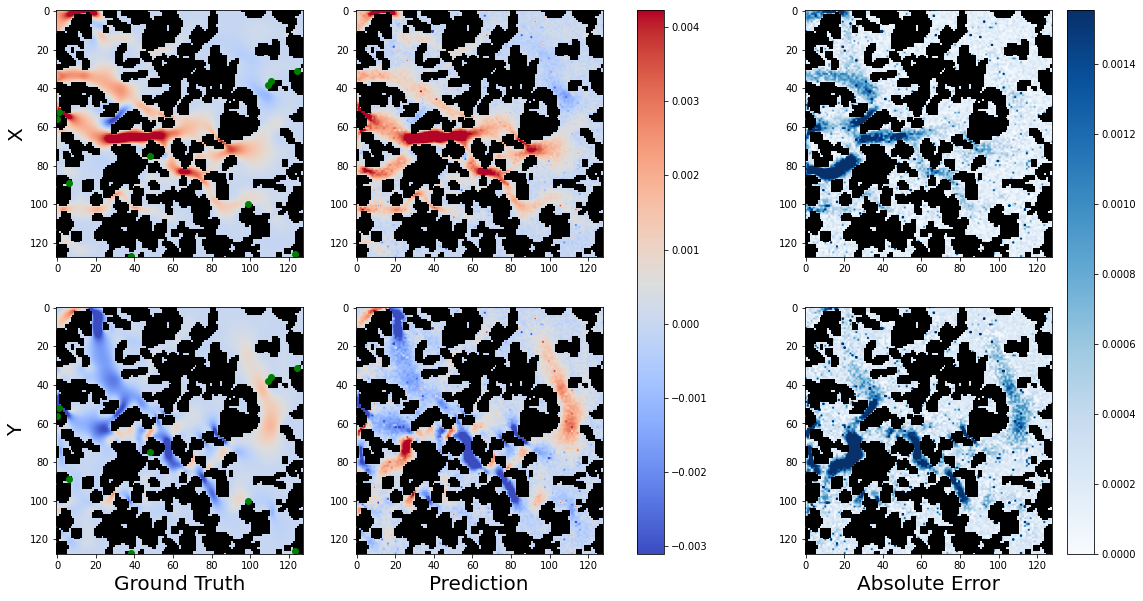

In [ ]:
#visualization
print('Visualization of results :)')
fig, ax = plt.subplots(2,3,figsize = (19,10))
#my porousing secret :(
for i in range(3):
    ax[0,i].set_facecolor((0., 0., 0.))
    ax[1,i].set_facecolor((0., 0., 0.))
ax[0,0].set_ylabel('X', fontsize = 20)
ax[1,0].set_ylabel('Y', fontsize = 20)

a = np.nanmin(np.vstack([np.vstack([pred_f_0,pred_f_1]),np.vstack([orig_f_0,orig_f_1])]))/5;
b = np.nanmax(np.vstack([np.vstack([pred_f_0,pred_f_1]),np.vstack([orig_f_0,orig_f_1])]))/3;
ax[0,0].imshow(orig_f_0, cmap='coolwarm',vmin = a, vmax =b);
ax[1,0].imshow(orig_f_1, cmap='coolwarm',vmin = a, vmax =b);
ax[0,1].imshow(pred_f_0, cmap='coolwarm',vmin = a, vmax =b);
im = ax[1,1].imshow(pred_f_1, cmap='coolwarm',vmin = a, vmax =b);

a = 0#np.nanmin(np.vstack([g_f_0,g_f_1]))/3; 
b = np.nanmax(np.vstack([g_f_0,g_f_1]))/10
ax[0,2].imshow(g_f_0, cmap='Blues',vmin = a, vmax =b);
im1 = ax[1,2].imshow(g_f_1, cmap='Blues', vmin = a, vmax = b);

#get guages
g0,g1 = np.array(dataset.guage_space).T
ax[0,0].scatter(g1,g0,color='green',alpha=1)
ax[1,0].scatter(g1,g0,color='green',alpha=1)

# ax[0,0].set_title(f'Model Trained with {len(guage_space)} sensors',fontsize = 35)
ax[1,0].set_xlabel('Ground Truth', fontsize=20)
ax[1,2].set_xlabel('Absolute Error', fontsize=20)
ax[1,1].set_xlabel('Prediction', fontsize=20)
# plt.colorbar(im,ax = ax.ravel().tolist())
plt.colorbar(im,ax = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]])
plt.colorbar(im1,ax = [ax[0,2],ax[1,2]])
plt.savefig(f"./Models/{chkpt[chkpt.rfind('/')+1:chkpt.rfind('.')]}.png")

In [ ]:
##NME
for i, (x,y) in enumerate(validation_loader):
  if torch.cuda.is_available():
      input, output = x.cuda(), y.cuda()
  if i == 0:
    output_stack = output
    pred_stack = model(input.float())
  else:
    output_stack = torch.cat([output_stack,output])
    pred_stack = torch.cat([pred_stack,model(input.float())])
  # print(output_stack.shape, pred_stack.shape)
error = torch.linalg.norm(output_stack - pred_stack)/torch.linalg.norm(output_stack)
print(f'Normalized Error: {error}')

Normalized Error: 0.41189995408058167


In [ ]:
##NFE
target = output_stack - output_stack.mean(dim =0)
pred = pred_stack - output_stack.mean(dim =0)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print(f'Normalized Error: {error}')

Normalized Error: 0.7317818403244019


In [ ]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

r2_loss(pred_stack,output_stack)

tensor(0.8014, device='cuda:0', grad_fn=<RsubBackward1>)